# Mode fitting

Here we will make a simple hierarchical model that encodes some knowledge of quasi-equally spaced modes of oscillation into the prior.

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan

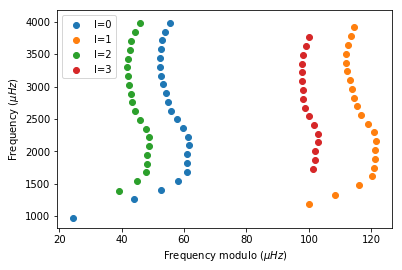

In [67]:
dnu_sol = 136  # book value of large freq separation for the sun

df = pd.read_table('broomhall2009.txt', delim_whitespace=True, names=('n', 'l', 'nu', 'nu_unc'))  #import data

lmodes = []
dnu_avg = []
f_mod = []

for i in range(4):
    lmodes.append(df[df.l == i])
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

The lower departure from a straight line is due to the BCZ, so the lower frequencies are not useful in analysing the response from the HeII ionization zone. Frequencies below 1700 $\mu$Hz are omitted.

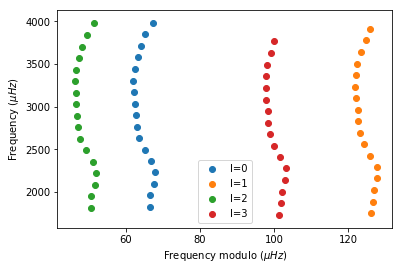

In [68]:
for i in range(4):
    lmodes[i] = lmodes[i].loc[lmodes[i].nu > 1700]
    lmodes[i] = lmodes[i].set_index(np.arange(0,len(lmodes[i]),1))

dnu_avg = []
f_mod = []
for i in range(4):
    dnu_avg.append(np.median(np.diff(lmodes[i].nu)))
    f_mod.append(lmodes[i].nu % dnu_avg[i])
    label = "l="+str(i)
    plt.scatter(f_mod[i], lmodes[i].nu, label = label)
    
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

To find a ballpark figure before defining priors, I will apply the model from Vrard:

$$\nu_{UP}(n,0)=\bigg(n+\epsilon+\frac{\alpha}{2}(n-n_{max})^2+\frac{\mathcal{A}\mathcal{G}}{2\pi}sin\bigg(\frac{2\pi(n-n_{max})}{\mathcal{G}}+\phi\bigg)\bigg)\langle\Delta\nu\rangle$$

which I will simplify to:

$$\nu_{UP}(n,0)=\bigg(n+\epsilon+\frac{\alpha}{2}x^2+ABsin(x/B+\phi)\bigg)\langle\Delta\nu\rangle$$

where $x = n-n_{max}$ and $B = \frac{\mathcal{G}}{2\pi}$

In [463]:
def model(n, dnu, numax, epsilon, alpha, A, G, phi):
    nmax = numax/dnu + epsilon
    freqs = (n + epsilon + (alpha/2)*(n-nmax)**2 + (A*G/2*np.pi)*np.sin(2*np.pi*(n-nmax)/G + phi))*dnu #Vrard universal pattern
    return freqs

In [476]:
n = lmodes[0].n
dnu = dnu_avg[0]
numax = 2800
epsilon = 1.45
alpha = 0.003 #from vrard paper
A = 0.001
G = 211
phi = 0
f = model(n, dnu, numax, epsilon, alpha, A, G, phi)

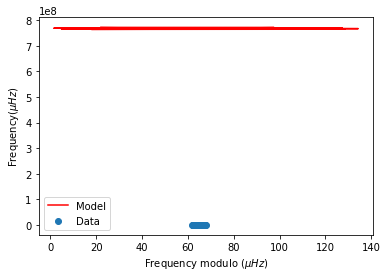

In [477]:
plt.scatter(f_mod[0], lmodes[0].nu, label = 'Data')
plt.plot(f % dnu_avg[0], f, label = 'Model', color = 'r')
plt.ylabel(r'Frequency($\mu Hz$)')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.legend()
#plt.xlim(0, 135.2)

In [451]:
code = '''
functions {
    real model(real n, real dnu, real epsilon, real alpha, real A, real x, real B, real phi){
        real freqs = (n + epsilon + (alpha/2)*x^2 + A*B*sin(x/B + phi))*dnu; //Vrard universal pattern
        return freqs;
    }
}
data {
    int N; // Data points
    real n[N];
    real dnu;
    real fobs[N];
    real xdat[N];
}
parameters {
    real epsilon;
    real alpha;
    real A;
    real B;
    real<lower=-pi(), upper=pi()> phi;
    real x[N];
}
model {
    vector[N] mod;
    epsilon ~ normal(1.45, 0.6);
    alpha ~ normal(0.00312, 0.001);
    A ~ normal(0.01, 1);
    x ~ normal(xdat, 1);
    B ~ normal(0.3, 1);
    phi ~ normal(0, pi());
    for (i in 1:N) mod[i] = model(n[i], dnu, epsilon, alpha, A, x[i], B, phi);
    mod ~ normal(fobs, 1);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_4864d4be8abfb2296d3f2adcd075efe2 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmpx_1wrb8q/stanfit4anon_model_4864d4be8abfb2296d3f2adcd075efe2_3009326761017122469.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [452]:
stan_data = {'N': len(lmodes[0]), 'n': lmodes[0].n,
             'fobs': lmodes[0].nu, 'dnu': dnu_avg[0],
             'xdat': x
            }
nchains = 4
#start = {'A': 3, 'G': 4, 'phi': 1}
fitsm = sm.sampling(data=stan_data, iter=10000, chains=nchains) #init=[start for n in range(nchains)])

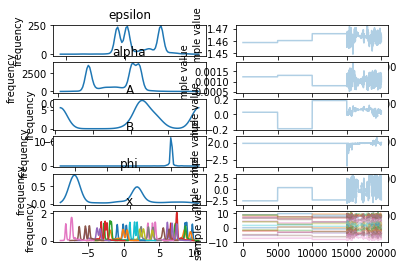

In [453]:
fitsm.plot()
plt.show()

In [454]:
print(fitsm)

Inference for Stan model: anon_model_4864d4be8abfb2296d3f2adcd075efe2.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
epsilon   1.46  2.0e-3 3.2e-3   1.46   1.46   1.46   1.47   1.47      3   2.15
alpha   1.1e-3  1.4e-4 2.1e-4 8.0e-4 8.0e-4 1.2e-3 1.3e-3 1.3e-3      2   2.57
A         0.02    0.09   0.13  -0.19  -0.12   0.03   0.15   0.18      2  10.46
B        -0.01    0.02   0.16  -0.163.3e-13 1.6e-7 5.6e-5   0.11     60   1.07
phi      -1.07    1.01   1.62  -2.59  -2.59  -2.39   0.32   2.45      3   2.27
x[1]      8.89    0.36    0.6   7.57   8.68    8.9   9.69   9.69      3   2.01
x[2]      8.17    0.78   1.13   6.43   6.43    8.6   9.43   9.43      2   4.14
x[3]      7.95    0.45   0.75   7.23   7.23   7.43   8.72   9.33      3   2.01
x[4]      7.39    0.32   0.56   6.66   6.66   7.44   7.55   8.77      3    1.8
x[5]      6.78    0

In [462]:
xs = []
for i in range(17):
    xs.append(fitsm['x'][i+1].mean())
stanfit = model(lmodes[0].n, dnu_avg[0], fitsm['epsilon'].mean(), fitsm['alpha'].mean(), fitsm['A'].mean(), xs, fitsm['B'].mean(), fitsm['phi'].mean())

plt.subplots()
plt.scatter(f_mod[0], lmodes[0].nu, label = 'Data')
plt.scatter(stanfit % dnu_avg[0], stanfit, label = 'Stan model')
plt.legend()

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'int'

The model describes this data rather well when using parameters: $\nu_{max}$ = 2800, $\epsilon$ = 1.45, $\alpha$ = 0.0031212, $A$ = 3.77$\times$10$^{-6}$, $G$ = 212.16 and $\phi$ = 0. Now apply stan model to try and improve these.

In [456]:
import corner
data = np.vstack([fitsm['epsilon'], fitsm['alpha'], fitsm['A'], fitsm['x'], fitsm['B'], fitsm['phi'],]).T
corner.corner(data, labels=[r'$\epsilon$', r'$\alpha$', r'$A$', r'$x$', r'$B$', r'$\phi$'])
plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly

This analysis will use the methods detailed in Vrard 2015 and, as such, will use its definitions.

The definition for the local frequency spacing is:

$\Delta\nu(n) = \frac{\nu_{n+1,0}-\nu_{n-1,0}}{2}$.

At the edges of the measured radial modes, we cannot use this equation and replace it by the frequency difference between two consecutive radial modes.

In [157]:
lmodes[0]['dnu_n'] = (lmodes[0]['nu'].diff(2).shift(-1)/2)
lmodes[0]['dnu_n'][0] = lmodes[0]['nu'].diff(1)[1]
lmodes[0]['dnu_n'][16] = (lmodes[0]['nu'].diff(1)[16])

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


We assume the frequency with largest amplitude is at $n=22$ meaning $\nu_{max} = 3168.618$. This is then used in the determination of the universal pattern to which the frequency separation will be compared:

$\Delta\nu_{UP}(n)=(1+\alpha(n-n_{max}))\langle\Delta\nu\rangle$

We compute the difference between the observed local large separation and the theoretical local large separation predicted by the universal pattern:

$\delta_{g,obs}=\Delta\nu(n)-\Delta\nu_{UP}(n)$

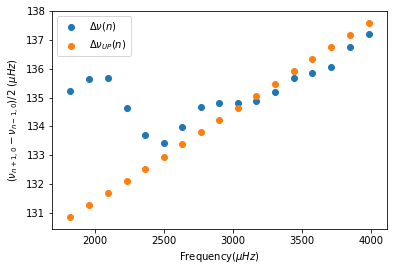

In [227]:
nmax = 22
numax = 3168.618
alpha = 0.015*dnu_avg[0]**(-0.32)
dnu_UP = (1+alpha*(lmodes[0].n-nmax))*dnu_avg[0]

plt.scatter(lmodes[0].nu, lmodes[0].dnu_n, label = r'$\Delta\nu(n)$')
plt.xlabel(r'Frequency($\mu Hz$)')
plt.ylabel(r'$(\nu_{n+1,0}-\nu_{n-1,0})/2$ ($\mu Hz$)')
plt.scatter(lmodes[0].nu, dnu_UP, label = r'$\Delta\nu_{UP}(n)$')
plt.legend()

We now subtract the universal pattern from the data in order to remove the curvature term.

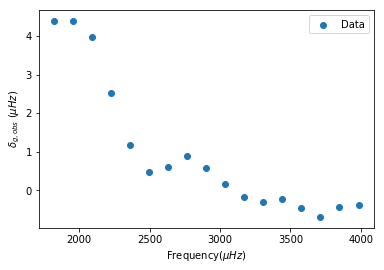

In [242]:
deltag = lmodes[0].dnu_n - dnu_UP

plt.scatter(lmodes[0].nu, deltag, label='Data')
plt.xlabel(r'Frequency($\mu Hz$)')
plt.ylabel(r'$\delta_{g,obs}$ ($\mu Hz$)')
plt.legend()

The amplitude can be found by fitting an oscillatory component to the resultant frequency variations obtained after removal of the curvature term from the measurements:

$\delta_{g,obs}=\mathcal{A}\langle\Delta\nu\rangle cos\big(\frac{2\pi(\nu-\nu_{max})}{\mathcal{G}\langle\Delta\nu\rangle}+\phi\big)$

where $\mathcal{G}$ is the period of the oscillation expressed in units of $\langle\Delta\nu\rangle$, $\mathcal{A}$ is the amplitude of the oscillation in units of $\langle\Delta\nu\rangle$ and $\phi$ is the phase of the oscillation centered on $\nu_{max}$.

In [235]:
code = '''
functions {
    real dgobs(real A, real numax, real nu, real G, real phi){
        return A * cos((2*pi()*(nu-numax))/G + phi);
    }
}
data {
    int N; // Data points
    real nu[N];
    real numax;
    real dnu_avg;
    real dg[N];
}
parameters {
    real<lower = 0> G;
    real<lower = 0> A;
    real<lower = 0> phi;
}
model {
    vector[N] mod;
    A ~ normal(4, 1.5);
    G ~ normal(7, 2);
    phi ~ normal(1.5*pi(), 1);
    for (i in 1:N) mod[i] = dgobs(A, numax, nu[i], G, phi);
    mod ~ normal(dg, 1);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a84c71713f5d490c50c75c3320d36a61 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmp9_i_sg4f/stanfit4anon_model_a84c71713f5d490c50c75c3320d36a61_4471298858285292731.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


The code takes a while to converge.  We run for 20000 iterations and check the results.

In [236]:
stan_data = {'N': len(lmodes[0]), 
             'nu': lmodes[0].nu, 'dg': deltag,
             'numax': numax, 'dnu_avg': dnu_avg[0]}
nchains = 4
start = {'A': 3, 'G': 4, 'phi': 1}
fitsm = sm.sampling(data=stan_data, iter=20000, chains=nchains, init=[start for n in range(nchains)])

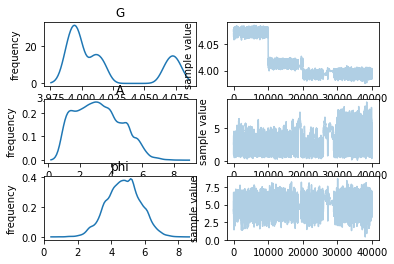

In [237]:
fitsm.plot()
plt.show()

In [238]:
print(fitsm)

Inference for Stan model: anon_model_a84c71713f5d490c50c75c3320d36a61.
4 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=40000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
G      4.02    0.02   0.03   3.99   3.99    4.0   4.04   4.08      2   7.37
A      3.21    0.13   1.44   0.93   2.05   3.12   4.24   6.01    116   1.06
phi    4.74    0.06    1.0   2.75   4.06   4.75   5.41   6.63    266   1.02
lp__ -23.19    0.05   1.46 -26.64 -24.06 -22.83 -22.07 -21.33    905   1.01

Samples were drawn using NUTS at Thu Nov 29 14:07:22 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


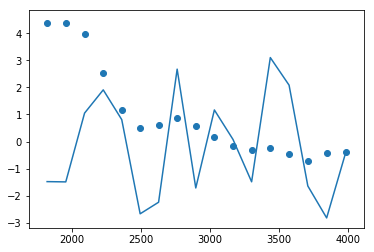

In [239]:
dgstan = fitsm['A'].mean() * np.cos((2*np.pi*(lmodes[0].nu-numax))/fitsm['G'].mean() + fitsm['phi'].mean())

plt.subplots()
plt.plot(lmodes[0].nu, dgstan, label = 'Stan model')
plt.scatter(lmodes[0].nu, deltag, label = 'Data')

Here is a corner plot of the results:

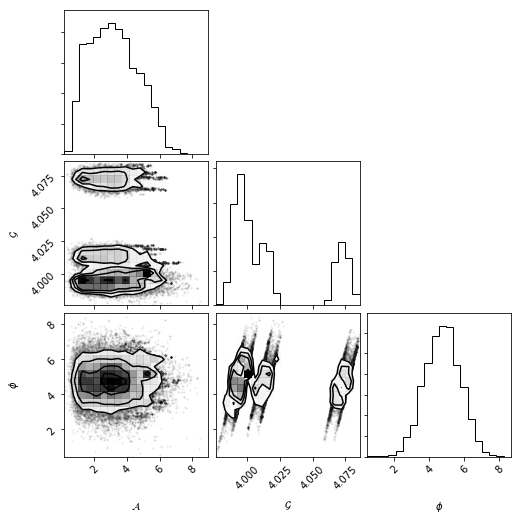

In [240]:
import corner
data = np.vstack([fitsm['A'], fitsm['G'], fitsm['phi']]).T
corner.corner(data, labels=[r'$\mathcal{A}$', r'$\mathcal{G}$', r'$\phi$'])
plt.show()

From Nature volume 215, pages 43–44 (01 July 1967) the helium mass fraction of the sun is between 0.20 and 0.27.